For analysis we create an SA CCR object that implements SA CCR as specified in <cite data-cite="SACCR"(BCBS, 2014)</cite>

When using *SA-CCR* the exposure at default (EAD) has to be calculated as:

\begin{align*}
EAD &= \alpha * (RC + PFE)\\
\\
\text{where} \qquad \alpha&=1.4 \\
RC&: \text{Replacement Cost} \\
PFE&: \text{Potential Future Exposure}
\end{align*}


In [1]:

from numpy import meshgrid
from sa_ccr.sa_ccr import SA_CCR
from jupyterUtils import export, graphicsFolder, exportPlotlyFigure
import pandas as pd
asdf = 1

sa_ccr = SA_CCR()



In [2]:
SA_CCR.calculate_sa_ccr_ead(rc = 10, pfe = 20)

42.0


#### Relation of RC and PFE

The purpose of the RC is to assess the imidiate loss suffered by the default of a counterparty. It is based on the current MtM of the derivative less the accessible collateral. If a bank has posted collateral to non-segregated accounts of a counterparty this collateral is also assumed to be lost in case of a default which increases the replacement cost.

The potential future exposure (PFE) on the other hand assesses how the RC might develop in the future. The future being defined as during the next year. If the RC today is 0 but is likely to be larger than 0 in the near future the estimated EAD should take this expected increase in RC into account.

See also Paragraph 130 and 131 of <cite data-cite="SACCR"(BCBS, 2014)<\cite> :

Paragraph 130 - case without margining:

> For unmargined transactions, the *RC* intends to caputre the loss that would occur if a counterparty were to default and were closed out of its transactions immediately. The *PFE* add-on represents a potential conversative increase in expousre over a one-year time horizon from the present date (i.e. the calculation date).

Paragraph 131 - case with margining:

> For margined trades, the *RC* intends to capture the loss that would occur if a counterparty were to default at the present or at a future time, assuming that the closeout and replacement of transactions occur instantaneously. However, there may be a period (the margin period of risk) between the last exchange of collateral before default and replacement of the trades in the market. The *PFE* add-on represents the potential change in value of the trades during this time period.



#### Definition of Potential Future Exposure (PFE)

\begin{align*}
PFE &= \text{multiplier} * AddOn^{\text{aggregate}} \\
\\
\text{where} \qquad AddOn^{\text{aggregate}} &: \text{aggregate add-on component} \\
\text{multiplier} &: f(V,C,AddOn^{\text{aggregate}})
\end{align*}

$AddOn$ is calculated differently for each asset $a$ class. Since no netting is allowed between asset classes the aggregate is calculated as:

$$AddOn^{\text{aggregate}} = \sum_{a}AddOn^{a}$$

Collateralization is taken into account of the PFE calculation through the multiplier that uses the collateral held as an input. As overcollateralization e.g. through IM increases, the multiplier decreases. However, the multiplier is floored at 5%.

\begin{align*}
\text{multiplier} &= \min \left\{ 1; Floor + (1-Floor) \exp\left(\frac{V-C}{2(1-Floor)AddOn^{\text{aggregate}}}\right) \right\} \\
\text{where} \qquad Floor &= 5\%
\end{align*}

It is important to note that the multiplier can only be below 1 if $C>V$, i.e. if the portfolio is overcollateralized. If the portfolio is overcollateralized, the *AddOn* comes into play. The idea behind the *AddOn* is related to the idea of value at risk. The higher the *AddOn* the faster the SA-CCR model expects the positions to lose in value. Therefore, the higher the value, the higher the multiplier.

In the example below the current NPV of the portfolio is 30 and the received collateral (*IM* + *VM*) is 37. The portfolio is overcollateralized as it should be when initial margin is used. On the other hand, as collateralization decreases e.g. V=C since only VM is exchanged or C=0 in the case of an uncollateralized portfolio the multiplier increases.

In [3]:
parameters = [[30, 37, 5],
[30, 30, 5],
[30, 0, 5]]

for par in parameters:
    print('NPV of %d collateral of %d and AddOn of %d yields a multiplier of %.6f' % tuple(par + [SA_CCR.multiplier(*par)]))

NPV of 30 collateral of 37 and AddOn of 5 yields a multiplier of 0.504692
NPV of 30 collateral of 30 and AddOn of 5 yields a multiplier of 1.000000
NPV of 30 collateral of 0 and AddOn of 5 yields a multiplier of 1.000000


In [4]:
#attempt to display the multiplier as a function in threedimensional space.
#Creating the data
import numpy as np
V = 1
Cs = np.arange(0.5, 2, .01)
AddOns = np.arange(0.01, 1.5, 0.01)

Matrix = np.array([[SA_CCR.multiplier(V, C, AddOn) for C in Cs] for AddOn in AddOns])

CMesh, AddOnMesh = meshgrid(Cs, AddOns)

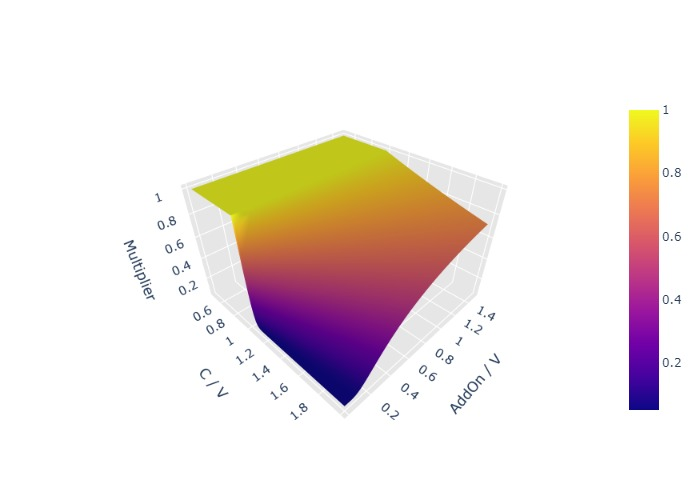

In [5]:
# Creating the plot

import plotly.graph_objects as go

surface = go.Surface(x=AddOnMesh, y=CMesh, z=Matrix)
data = [surface]

layout = go.Layout(
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            autorange='reversed'
            
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            dtick = 0.2
        ),
        xaxis_title = 'AddOn / V',
        yaxis_title = 'C / V',
        zaxis_title = 'Multiplier'
    )
)
camera = dict(
    center=dict(x=0, y=0, z=-0.1),
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(scene_camera=camera)
img_bytes = fig.to_image(format="jpeg")
from IPython.display import Image
Image(img_bytes)

In [6]:
exportPlotlyFigure(fig=fig, name='SACCR_Multiplier_Function')

In [8]:
asdf =1
export('building_SA_CCR.ipynb')